In [1]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.set_printoptions(precision=1,suppress=True)

In [2]:
rh = RoundHill()
X = rh.experiments[0].X
Y = rh.experiments[0].Y #scaling
boundary = proposeboundary(X)
boundary[0][2]=-30 #puts the source on the grid!
boundary[0][0]=-120 #add two minutes to start

In [42]:
#set up our model...
N_feat = 10000 #Number of features used to infer the source
#k = EQ(np.array([50,12,12]), 1000)
k = EQ(np.array([50,10,10]), 1000)
res = [150,100,100]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
print("Memory usage in grid model: %0.2f Gb" % gbs)
#assert gbs<6, "TOO BIG :("
noiseSD = 0.1
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(rh.experiments[0].windX,rh.experiments[0].windY)
k_0 = 1
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference


Memory usage in grid model: 4.02 Gb


In [43]:
mInfer.computeModelRegressors(Nparticles=30) # Compute regressor matrix
print("Computed Regressors")
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix

Initialising particles...
Diffusing particles...
Computed Regressors
Computing SS...
Inverting SS...
Computing meanZ
Done


In [44]:
Nsamps = 1
if Nsamps==1:
    Zs = meanZ[None,:]
else:
    Zs = np.random.multivariate_normal(meanZ,covZ,Nsamps)
    
sources = np.array([mInfer.computeSourceFromPhiInterpolated(z) for z in Zs])
sourcemean = np.mean(sources,0)
sourcevar = np.var(sources,0)

cache miss, computing source from phi...
Computing Source from Phi...


In [45]:
#concmean,concvar = mInfer.computeConcentration(meanZ,covZ,Nsamps=5,Nparticles=25,interpolateSource=True)
scaleby = [8,1,1]
coords = mInfer.coords[:,::scaleby[0],::scaleby[1],::scaleby[2]]
concmean,concvar,concentrations = mInfer.computeConcentration(Nparticles=50,Zs=Zs,interpolateSource=True,coords=coords)

Initialising particles...
Particle shape:
(50, 19, 100, 100, 3)
Diffusing particles...


In [46]:
gridsource = mInfer.getGridCoord(np.array([0,0,0])) #location of ground truth source
gridX = mInfer.getGridCoord(X[:,1:])/np.array(scaleby) #grid-coords of X (inputs)
mInferCoords = mInfer.coords

In [47]:
import pickle
results = {
    'gridsource':gridsource,
    'gridX':gridX,
    'mInferCoords':mInferCoords,
    'scaleby':scaleby,
    'sourcemean':sourcemean,
    'sourcevar':sourcevar,
    'concmean':concmean,
    'concvar':concvar,
    'X':X,
    'Y':Y
    }
pickle.dump(results,open('RHexampleTEMP2.pkl','wb'))

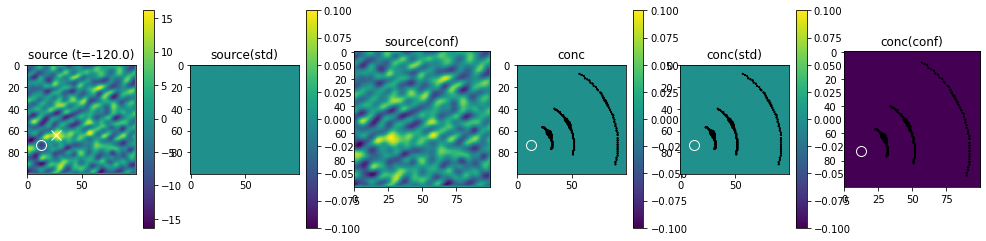

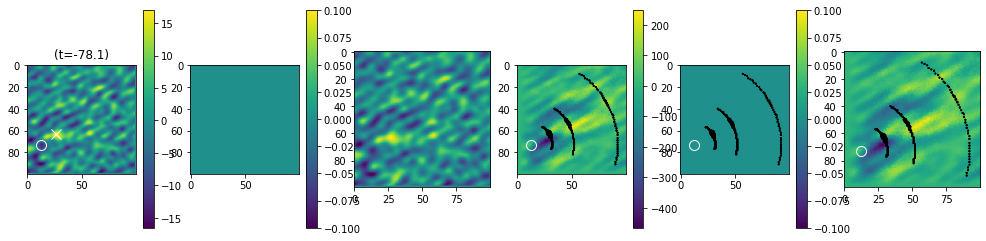

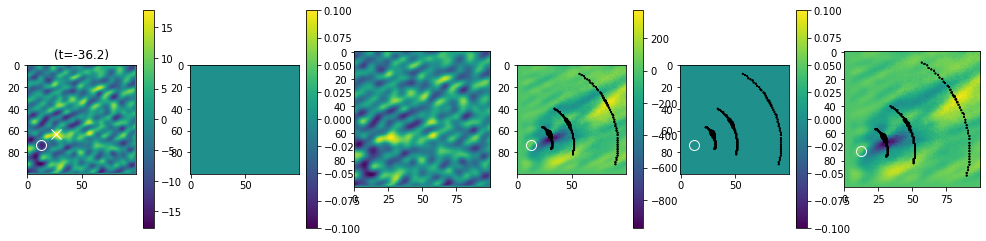

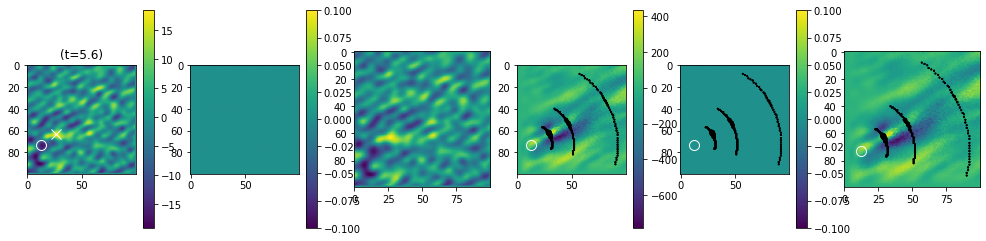

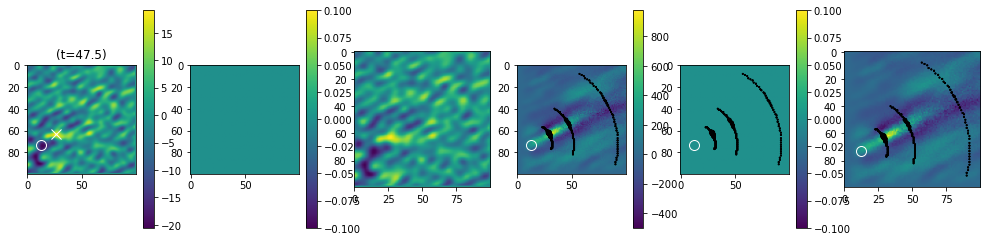

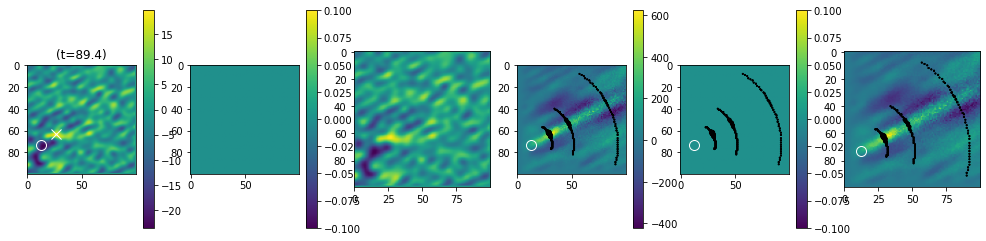

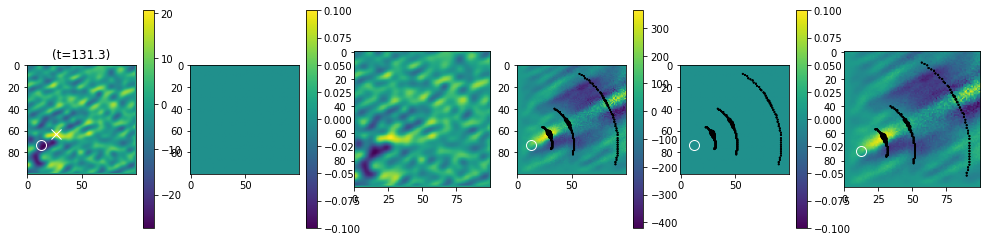

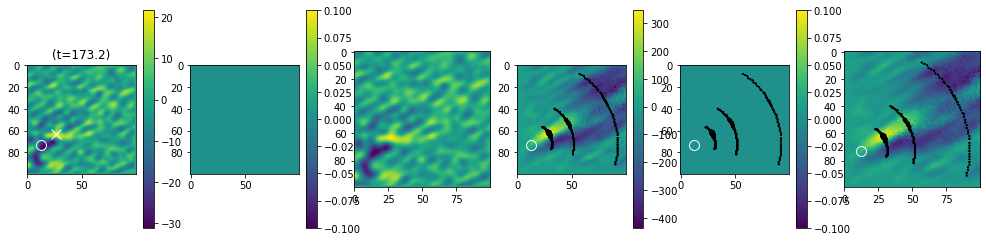

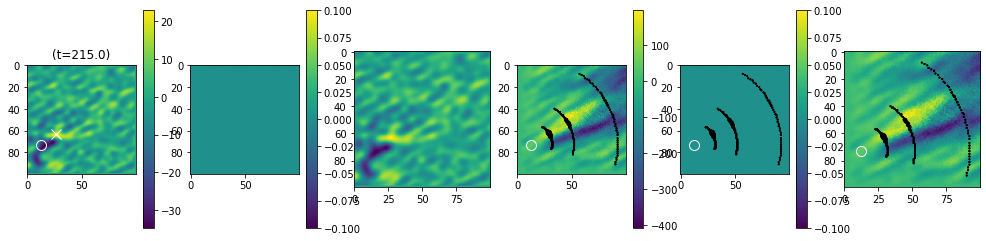

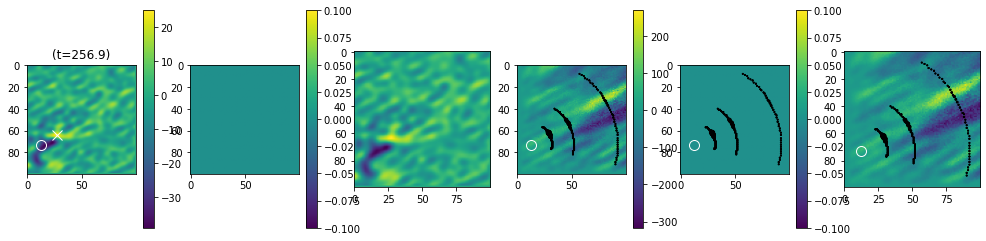

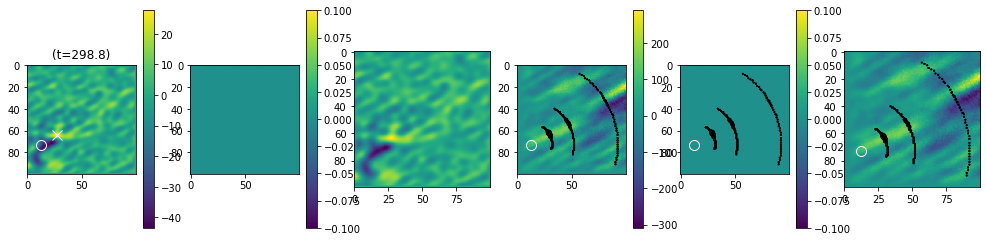

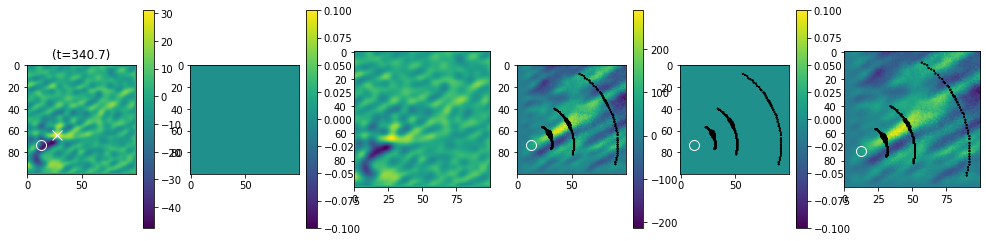

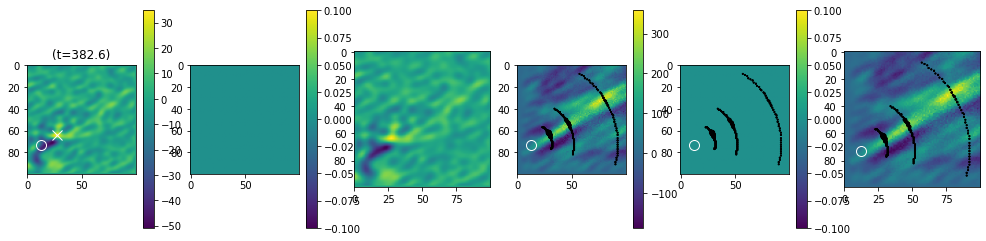

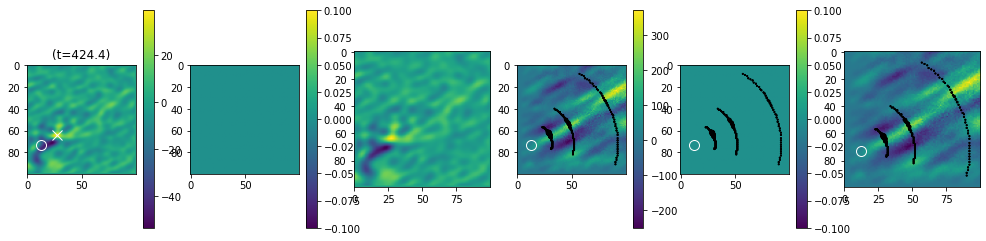

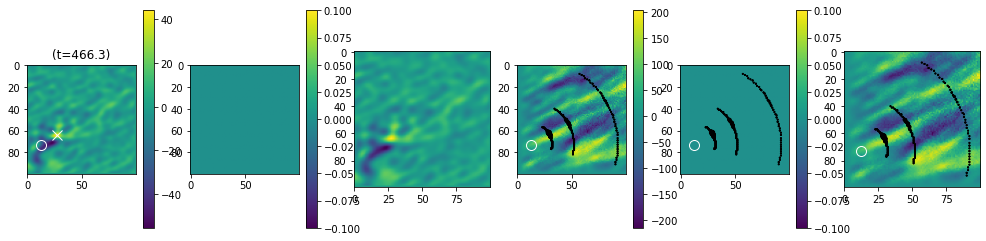

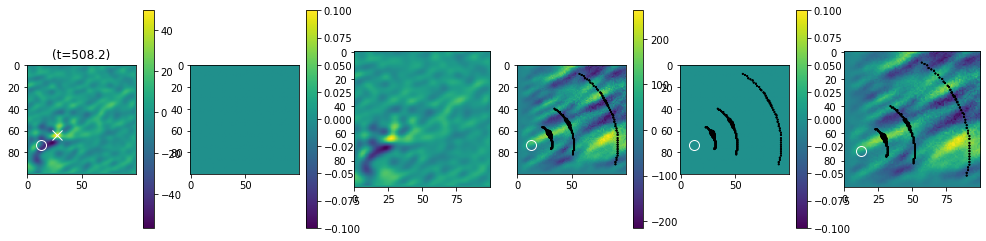

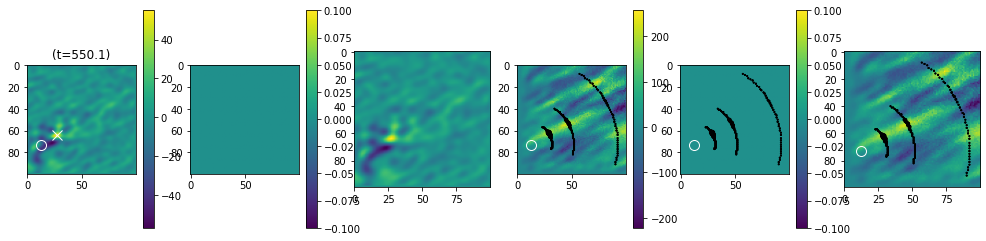

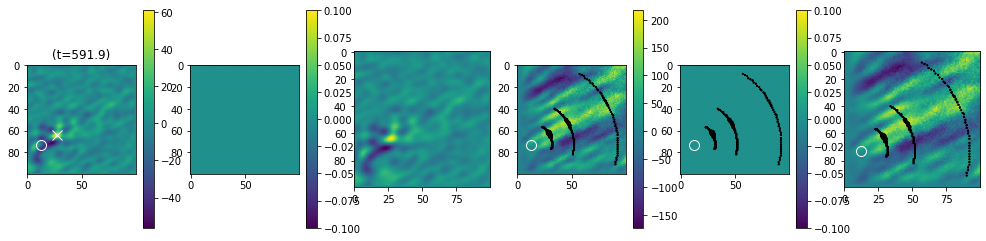

In [84]:
for tsamp in range(0,int(mInferCoords.shape[1]/scaleby[0]),1):
    plt.figure(figsize=[20,4])
    
    plt.subplot(1,7,1)
    t = mInferCoords[0,tsamp*scaleby[0],0,0]
    if tsamp==0: 
        plt.title('source (t=%0.1f)' % t)
    else:
        plt.title('(t=%0.1f)' % t)
    plt.imshow(sourcemean[tsamp,:,:])
    #plt.clim([-1,3])
    plt.colorbar()
    plt.plot(gridsource[2],gridsource[1],'ow',markersize=10,fillstyle='none')
    i,j = getmaxloc(sourcemean[tsamp,:,:])
    plt.plot(j,i,'xw',markersize=10,fillstyle='none')
    plt.subplot(1,7,2)  
    if tsamp==0: plt.title('source(std)')
    plt.imshow(np.sqrt(sourcevar[tsamp,:,:]))
    #plt.clim([0,0.5])    
    plt.colorbar()
    plt.subplot(1,7,3)
    if tsamp==0: plt.title('source(conf)')
    vals = sourcemean[tsamp,:,:]
    alphas = np.sqrt(sourcevar[tsamp,:,:])<2
    plt.imshow(vals,alpha=alphas.astype(float))
    #plt.clim([-1,3])
    plt.subplot(1,7,4)
    if tsamp==0: plt.title('conc')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    plt.imshow(concmean[tsamp,:,:])
    plt.colorbar()
    #plt.clim([0,15])
    #plt.clim([-5,5])
    #plt.colorbar()
    plt.plot(gridsource[2],gridsource[1],'ow',markersize=10,fillstyle='none')
    plt.subplot(1,7,5)
    if tsamp==0: plt.title('conc(std)')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    plt.imshow(np.sqrt(concvar[tsamp,:,:]))
    plt.colorbar()
    #plt.clim([0,0.5])
    #plt.colorbar()
    plt.plot(gridsource[2],gridsource[1],'ow',markersize=10,fillstyle='none')
    plt.subplot(1,7,6)
    if tsamp==0: plt.title('conc(conf)')
    plt.scatter(gridX[:,2],gridX[:,1],1+Y/50,color='black')
    vals = concmean[tsamp,:,:]
    alphas = np.sqrt(concvar[tsamp,:,:])<50
    plt.imshow(vals,alpha=alphas.astype(float))
    #plt.clim([0,15])
    #plt.clim([-5,5])
    plt.plot(gridsource[2],gridsource[1],'ow',markersize=10,fillstyle='none')
    #plt.subplot(1,7,7)
    #if tsamp==0: plt.title('realconc')
    #plt.scatter(tempgridX[:,1],tempgridX[:,2],1,color='black')
    #plt.imshow(realconc[tsamp//scaleby[0],:,:])    
    #plt.clim([0,15])
    #plt.colorbar()
    
    #t = ts[tsamp*10]
    #plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*5,color='red')
    #

In [122]:
mInfer.coords[:,135,0,0]

array([ 586.7, -186. ,  -30. ])

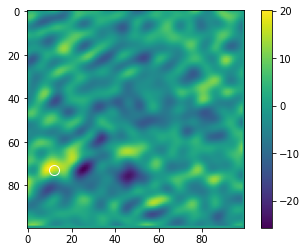

In [115]:
plt.imshow(sourcemean[50,:,:])
#plt.clim([5,30])
plt.colorbar()
plt.plot(gridsource[2],gridsource[1],'ow',markersize=10,fillstyle='none')

In [136]:
dt,dx,dy,_,_,_,_,_ =mInfer.getGridStepSize()


32.75584

In [149]:
np.mean(np.sum(sourcemean,(1,2))*dt*dx*dy)
#np.mean(np.sum(sourcemean[25:135,60:80,40:65],(1,2))*dt*dx*dy)

-52028.80465151217

In [144]:
np.mean(np.sum(sourcemean[25:135,0:25,60:80],(1,2))*dt*dx*dy)

4101.911361535356

In [126]:
np.array(boundary[1])-np.array(boundary[0])

array([780., 254., 248.])

In [94]:
np.sqrt((boundary[1][1]-boundary[0][1])**2 + (boundary[1][2]-boundary[0][2])**2)

354.9929576766277

In [124]:
def getmaxloc(a):
    return np.unravel_index(a.argmax(), a.shape)

poses = []
for tsamp in range(25,135):
    i,j = getmaxloc(sourcemean[tsamp,:,:])
    pos = mInfer.coords[:,tsamp,i,j]
    poses.append(pos)
    #print(pos)
np.sqrt(np.median(poses,0)[1]**2+np.median(poses,0)[2]**2)

45.64362469679296

In [49]:
#mInfer.genParticlesFromObservations(20).shape

In [50]:
#concmean,concvar,concentrations = mInfer.computeConcentration(Nparticles=5,Zs=Zs,interpolateSource=True,coords=coords)

In [51]:
particles = mInfer.genParticlesFromObservations(100)[None,None,:,:,:].transpose([3,0,1,2,4])

In [52]:
#p = mInfer.coords.transpose([1,2,3,0]).copy()
#p = p[None,:].repeat(12,axis=0)

In [53]:
#p.shape

In [54]:
#particles.shape

In [55]:
meanobs,varobs,obs = mInfer.computeConcentration(particles=particles,Zs=Zs,interpolateSource=True)

Initialising particles...
Particle shape:
(100, 1, 1, 351, 3)
Diffusing particles...


69


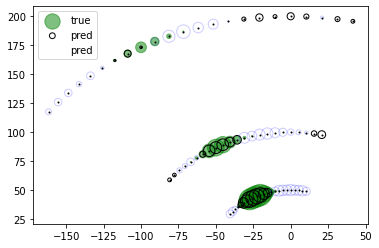

In [74]:
keep = X[:,1]==600
print(sum(keep))
plt.scatter(X[keep,2],X[keep,3],Y[keep],c='green',alpha=0.5,label='true')
plt.scatter(X[keep,2],X[keep,3],meanobs[0,0,keep],alpha=1,c='none',edgecolors='k',label='pred')
plt.scatter(X[keep,2],X[keep,3],-meanobs[0,0,keep],alpha=0.2,c='none',edgecolors='b',label='pred')
plt.scatter(X[keep,2],X[keep,3],1,c='k')
plt.legend()

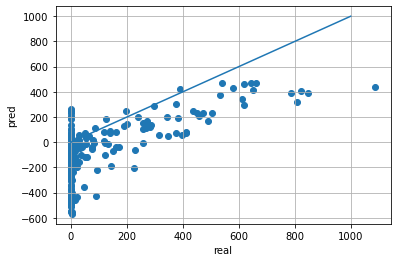

In [75]:
keep = X[:,1]>=0
plt.scatter(Y[keep],meanobs[0,0,keep])
plt.xlabel('real')
plt.ylabel('pred')
plt.plot([0,1000],[0,1000])
plt.grid()

Text(0, 0.5, 'pred')

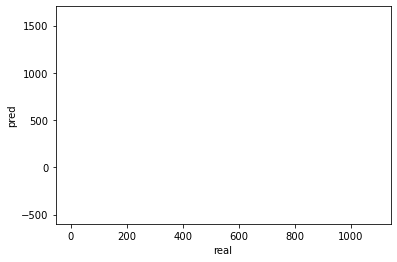

In [19]:
plt.errorbar(Y,meanobs[0,0,:],np.sqrt(varobs[0,0,:]),fmt='none')
plt.xlabel('real')
plt.ylabel('pred')

In [20]:
meanobs.shape

(1, 1, 351)

In [21]:
obs.shape

(1, 1, 1, 351)